In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

In [52]:
game_stats = pd.read_csv('../csv/game_stats.csv')
game_stats["totalGoals"] = game_stats["home_goals"] + game_stats["away_goals"]
game_stats = game_stats[game_stats["totalGoals"] < 10]  # remove outliers 99% of games will be kept
del game_stats["Unnamed: 0"]
del game_stats["home_goals"]
del game_stats["away_goals"]
del game_stats["home_powerPlayGoals"]
del game_stats["away_powerPlayGoals"]
del game_stats["home_powerPlayOpportunities"]
del game_stats["away_powerPlayOpportunities"]

game_stats = game_stats.drop_duplicates()
game_stats = game_stats.dropna()

game_stats

,home_pim,home_shots,home_powerPlayPercentage,home_faceOffWinPercentage,home_blocked,home_takeaways,home_giveaways,home_hits,away_pim,away_shots,away_powerPlayPercentage,away_faceOffWinPercentage,away_blocked,away_takeaways,away_giveaways,away_hits,totalGoals
2,10,29,0.0,68.2,17,5,2,23,12,15,33.3,31.8,8,6,4,23,6
5,10,27,0.0,51.6,13,8,16,45,4,40,40.0,48.4,4,3,9,22,4
9,4,41,50.0,41.4,18,4,10,24,4,15,50.0,58.6,11,4,9,13,7
10,2,46,50.0,45.6,9,8,12,29,6,39,0.0,54.4,13,6,6,20,7
11,2,24,66.7,57.1,7,3,19,23,6,34,0.0,42.9,15,9,9,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21383,4,32,0.0,52.6,15,5,9,29,8,19,0.0,47.4,23,6,7,33,4
21384,4,23,0.0,43.9,23,14,19,20,6,24,50.0,56.1,17,8,7,13,3
21386,9,32,0.0,63.6,13,4,12,27,9,37,0.0,36.4,17,7,10,27,7
21390,4,37,75.0,49.0,6,3,11,9,8,21,0.0,51.0,10,3,2,17,5


In [53]:
col_names = [col for col in game_stats.columns]


originalGoals = game_stats["totalGoals"]

# z = (x-mean)/std
# x = (z*std)+mean

original_mean = game_stats.mean()
original_std = game_stats.std()

game_stats_normalized =(game_stats-original_mean)/original_std
game_stats = game_stats_normalized
game_stats["totalGoals"] = originalGoals

features = np.array(game_stats.loc[:, game_stats.columns != 'totalGoals'],  dtype='float32')
# augment bias term to features
features = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1)
targets = np.array(game_stats['totalGoals'], dtype='int32')


x_train = features[:int(features.shape[0] * 0.8)]
t_train = targets[:int(targets.shape[0] * 0.8)]

x_val = features[int(features.shape[0] * 0.8): int(features.shape[0] * 0.9)]
t_val = targets[int(targets.shape[0] * 0.8): int(targets.shape[0] * 0.9)]

x_test = features[int(features.shape[0] * 0.9):]
t_test = targets[int(targets.shape[0] * 0.9):]


In [54]:
k_range = range(1, 75)
scores  = {}
scores_list = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train, t_train)
    y_pred = knn.predict(x_val)
    scores[k] = metrics.mean_squared_error(t_val, y_pred)
    scores_list.append(metrics.mean_squared_error(t_val, y_pred))

3.296125985589616

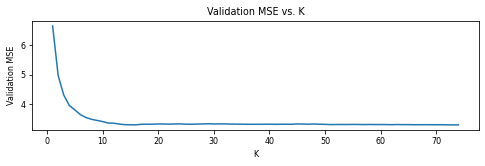

In [55]:
plt.rcParams["figure.figsize"] = (8, 2)
plt.rcParams["font.size"] = 8
plt.plot(k_range, scores_list)
plt.title("Validation MSE vs. K")
plt.ylabel("Validation MSE")
plt.xlabel("K")
min(scores_list)

In [56]:
# find the best k
k_best = min(scores, key=scores.get)
print(k_best, scores[k_best])

73 3.296125985589616


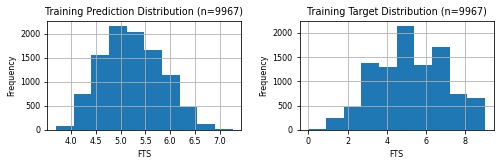

In [57]:
preds = knn.predict(x_train)
targets = t_train

pred_and_targets_df = pd.DataFrame({f'Training Prediction Distribution (n={len(preds)})': preds, f'Training Target Distribution (n={len(preds)})': t_train})
s = pred_and_targets_df.hist()
for ax in s.flatten():
    ax.set_xlabel("FTS")
    ax.set_ylabel("Frequency")

In [58]:
print("Training MSE:", metrics.mean_squared_error(targets, preds))
print(f"Prediction Mean: {preds.mean()}")
print(f"Prediction Std: {preds.std()}")
print(f"Target Mean: {targets.mean()}")
print(f"Target Std: {targets.std()}")

Training MSE: 3.3190008400988416
Prediction Mean: 5.236521060038667
Prediction Std: 0.598565760876108
Target Mean: 5.310825724892144
Target Std: 1.994651771161942


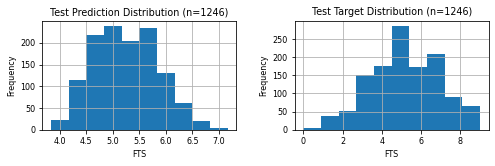

In [62]:
preds = knn.predict(x_test)
targets = t_test

pred_and_targets_df = pd.DataFrame({f'Test Prediction Distribution (n={len(preds)})': preds, f'Test Target Distribution (n={len(preds)})': targets})
s = pred_and_targets_df.hist()
for ax in s.flatten():
    ax.set_xlabel("FTS")
    ax.set_ylabel("Frequency")

In [61]:
print("Training MSE:", metrics.mean_squared_error(targets, preds))
print(f"Prediction Mean: {preds.mean()}")
print(f"Prediction Std: {preds.std()}")
print(f"Target Mean: {targets.mean()}")
print(f"Target Std: {targets.std()}")

Training MSE: 3.2758029492769847
Prediction Mean: 5.247429612598151
Prediction Std: 0.5945145321058944
Target Mean: 5.252006420545746
Target Std: 1.9584098571285078
